#From: BERT Fine-Tuning Tutorial with PyTorch
By Chris McCormick and Nick Ryan

*Revised on March 20, 2020 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*




In this tutorial I'll show you how to use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.

This post is presented in two forms--as a blog post [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) and as a Colab Notebook [here](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX). 

The content is identical in both, but: 
* The blog post includes a comments section for discussion. 
* The Colab Notebook will allow you to run the code and inspect it as you read through.

I've also published a video walkthrough of this post on my YouTube channel! [Part 1](https://youtu.be/x66kkDnbzi4) and [Part 2](https://youtu.be/Hnvb9b7a_Ps).



# Contents

See "Table of contents" in the sidebar to the left.

# Introduction


## History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.



## What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 



## Advantages of Fine-Tuning



In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

1. **Quicker Development**

    * First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.



### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!


[![BERT eBook Display Ad](https://drive.google.com/uc?export=view&id=1d6L584QYqpREpRIwAZ55Wsq8AUs5qSk1)](https://bit.ly/30JzuBH)


# 1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [4]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 42.2 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 61 kB 480 kB/s 
     |████████████████████████████████| 3.3 MB 39.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading CoLA Dataset


We'll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.


## 2.1. Download & Extract

In [5]:
import pandas as pd
raw_df=pd.read_excel('Chinese Complete Dataset.xlsx')
raw_df = raw_df[raw_df.Relevance<= 1]
raw_df = raw_df[raw_df['Article Sentiment']<= 3]
raw_df.head()

,Year,Article No,Sample_No,Relevance,Article Sentiment,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content
2,2002,36,NaN,1,3,3,1,3,5,4,XINCCN0020021209dyc90019j,3,中国明年将对房地产市场等进行专项整治,从１９９８年开始，中国先后开展了打击走私、骗汇、骗取出口退税和制售假伪劣商品等违法犯罪活动的...,整治集贸市场、加油站和旅游市场打假打非等今年以来部署的专项斗争，要抓住重点进一步加大力度，争...,中国明年将对房地产市场等进行专项整治\n从１９９８年开始，中国先后开展了打击走私、骗汇、骗取...
5,2002,51,NaN,1,3,4,1,4,8,4,XINCCN0020021216dyce000db,6,中国美容从业人员达２０００万,这２０００万从业者遍布于中国各地的１５４．２万家美容机构，平均每个就业者的年收入为２．４万人民币,这份调查中还提到，中国美容就业人员接受教育的程度略显偏低，人均就业时间很短，仅为４．８年,中国美容从业人员达２０００万\n这２０００万从业者遍布于中国各地的１５４．２万家美容机构，平...
14,2002,146,NaN,1,1,3,1,4,13,3,XINCCN0020021008dya800337,15,中俄高级经济论坛在京举行,中国人民大学党委书记程天权在开幕式上致辞说，去年中俄两国元首签署的《中俄睦邻友好合作条约》，...,目前，中国是俄罗斯第６大贸易伙伴，俄罗斯是中国的第８大贸易伙伴,中俄高级经济论坛在京举行\n中国人民大学党委书记程天权在开幕式上致辞说，去年中俄两国元首签署...
15,2002,152,NaN,1,3,3,1,3,2,3,XINCCN0020021113dybd000hr,16,中国女性在经济生活中擎起半片天,据了解，中国已在３１个省区市建立了再就业信息指导中心和下岗女工再就业培训基地，培训下岗女工５...,１０多年来，中国有１．２亿人次的农村妇女参加妇联组织的劳动竞赛，８０７万妇女脱贫，３０００万...,中国女性在经济生活中擎起半片天\n据了解，中国已在３１个省区市建立了再就业信息指导中心和下岗...
16,2002,157,NaN,1,1,4,1,4,19,4,XINCCN0020021122dyb9000rt,17,十条基本经验将对未来中国发展起长远指导作用,浙江团习近平代表说，中共十三届四中全会以来，中国走过了一条不平凡的道路,应该说，中国特色社会主义道路，经过多年的探索，在发展道路、阶段、任务以及步骤等方面都已经很清...,十条基本经验将对未来中国发展起长远指导作用\n浙江团习近平代表说，中共十三届四中全会以来，中...


In [6]:
# filter out articles with only positive and negative in all content
import pandas as pd
second_df = pd.read_excel('Chinese Complete Dataset.xlsx')
second_df = second_df[second_df.Relevance<= 1]
second_df = second_df[second_df['Article Sentiment']<= 3]
second_df = second_df[second_df['Headline Sentiment']<= 3]
second_df = second_df[second_df['First para. Sentiment']<= 3]
second_df = second_df[second_df['Last para. sentiment']<= 3]
second_df.head()




,Year,Article No,Sample_No,Relevance,Article Sentiment,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content
15,2002,152,NaN,1,3,3,1,3,2,3,XINCCN0020021113dybd000hr,16,中国女性在经济生活中擎起半片天,据了解，中国已在３１个省区市建立了再就业信息指导中心和下岗女工再就业培训基地，培训下岗女工５...,１０多年来，中国有１．２亿人次的农村妇女参加妇联组织的劳动竞赛，８０７万妇女脱贫，３０００万...,中国女性在经济生活中擎起半片天\n据了解，中国已在３１个省区市建立了再就业信息指导中心和下岗...
17,2002,164,NaN,1,1,1,1,3,7,3,XINCCN0020021110dyba0020c,18,李荣融说，过去１３年中国工业发展实现了历史性跨越,谈到国有企业改革时，李荣融说，国有企业改革是一场广泛、深刻的社会变革，是整个经济体制改革的中...,贯彻十六大精神，我们要进一步推进工业改组改造和结构优化升级，走出一条科技含量高、经济效益好、...,李荣融说，过去１３年中国工业发展实现了历史性跨越\n谈到国有企业改革时，李荣融说，国有企业改...
45,2002,405,NaN,1,1,1,1,3,5,3,XINCCN0020021004dya4002h9,46,中国的产业结构开始进入高级化阶段,按从业人员在三次产业中的分布衡量，１９７９年至２００１年中国产业结构的变化也十分明显，全社会...,从增加值的比重变化上看，国民经济总量增长从主要由第一、二产业带动转为主要由第二、三产业带动,中国的产业结构开始进入高级化阶段\n按从业人员在三次产业中的分布衡量，１９７９年至２００１年...
47,2002,414,NaN,1,1,1,1,3,57,1,XINCCN0020021209dyc80005s,48,２００２年：中国经济活力四射,国家统计局副局长邱晓华说，中国经济正在步入一个新的发展阶段，即从更多地靠政府政策主导经济增长...,在可预见的时期内，中国经济增长率将在２００２年的平台上稳步上扬,２００２年：中国经济活力四射\n国家统计局副局长邱晓华说，中国经济正在步入一个新的发展阶段，...
55,2002,499,NaN,1,1,1,1,3,9,1,XINCCN0020021213dyca0005q,56,（亚太专递）中日贸易投资继续走高,中国对日本出口的主要商品是纺织品、食品和矿产品等，从日本进口的主要商品是机电、化工产品和塑料...,”中国外经贸部亚洲司官员吴政平说，“两国经贸呈现总体增长的良好势头,（亚太专递）中日贸易投资继续走高\n中国对日本出口的主要商品是纺织品、食品和矿产品等，从日本...


In [7]:
len(second_df[second_df['Article Sentiment']==2])

43

In [8]:
second_df[(second_df['Article Sentiment']==2) & (second_df['Last para. sentiment'].isna())]

,Year,Article No,Sample_No,Relevance,Article Sentiment,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content


In [9]:
# take out articles for majority method testing; save articles method
import numpy as np
np.random.seed(0)

positive_indices = np.random.choice(second_df[second_df['Article Sentiment']==1].index, 43, replace=False)
negative_indices = np.random.choice(second_df[second_df['Article Sentiment']==2].index, 43, replace=False)
neutral_indices = np.random.choice(second_df[second_df['Article Sentiment']==3].index, 43, replace=False)

drop_indices = np.concatenate([positive_indices, negative_indices, neutral_indices])

test_dataframe = raw_df.filter(items = drop_indices, axis= 0)

raw_df = raw_df.drop(drop_indices)


In [10]:
#Augment Data Method
#raw_df = raw_df.dropna()

df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()

df1['Sentiment'] = raw_df['Headline Sentiment']
df2['Sentiment'] = raw_df['First para. Sentiment']
df3['Sentiment'] = raw_df['Last para. sentiment']
df4['Sentiment'] = raw_df['Article Sentiment']


df1['Content'] = raw_df['Headline']
df2['Content'] = raw_df['First Paragraph']
df3['Content'] = raw_df['Last Paragraph']
df4['Content'] = raw_df['Content']

df = pd.concat([df1, df2, df3, df4], ignore_index= True).dropna()
#df = df[(df.Sentiment<= 2) & (df.Sentiment> 0)] #positive vs negative
df = df[(df.Sentiment<= 3) & (df.Sentiment> 0)]  # neutral vs non-neutral


In [11]:
len(df)

5201

In [12]:
#downsampling 

# method 1 https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
import numpy as np
np.random.seed(0)

remove_n = 3390 #2250

new_drop_indices = np.random.choice(df[df['Sentiment'] == 3].index, remove_n, replace=False)

df = df.drop(new_drop_indices)

import numpy as np
np.random.seed(0)

remove_n = 1420 #300

new_drop_indices = np.random.choice(df[df['Sentiment'] == 1].index, remove_n, replace=False)

df = df.drop(new_drop_indices)


In [13]:
# 3 labels
df['Sentiment'] = df['Sentiment'].replace(2,0)
df['Sentiment'] = df['Sentiment'].replace(1,2)
df['Sentiment'] = df['Sentiment'].replace(3,1)




df.groupby('Sentiment').count()


,Content
Sentiment,
0,135
1,124
2,132


In [14]:
df.head()

,Sentiment,Content
50,0,新华社评论员：过多过滥的“招商引资”必须制止
67,2,调查显示，中国成为最有吸引力的外国直接投资目的国
82,2,亚行行长说，中国崛起将给亚洲带来空前的机遇
175,1,（中国－东盟博览会）中国－东盟自由贸易区建设将于 ２００５年全面启动
183,1,述评：中国以体制创新促进经济健康发展


In [15]:
# English addition method
import numpy as np
import pandas as pd

raw_df=pd.read_excel('English Complete Dataset.xlsx')
raw_df = raw_df[raw_df.Relevance<= 1]
raw_df = raw_df[raw_df['Article sentiment']<= 3]

df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()

df1['Sentiment'] = raw_df['Headline sentiment']
df2['Sentiment'] = raw_df['First para. sentiment']
df3['Sentiment'] = raw_df['Last para. sentiment']
df4['Sentiment'] = raw_df['Article sentiment']



df1['Content'] = raw_df['Headline']
df2['Content'] = raw_df['First Paragraph']
df3['Content'] = raw_df['Last Paragraph']
df4['Content'] = raw_df['Content']

en_df = pd.concat([df1, df2, df3, df4], ignore_index= True).dropna()


positive_use = np.random.choice(en_df[en_df.Sentiment==1].index, 1200, replace=False)
negative_use = np.random.choice(en_df[en_df.Sentiment==2].index, 1200, replace=False)
neutral_use = np.random.choice(en_df[en_df.Sentiment==3].index, 1200, replace=False)

use = np.concatenate([positive_use, negative_use, neutral_use])

en_df = en_df.filter(items=use, axis=0)

en_df['Sentiment'] = en_df['Sentiment'].replace(2, 0) # Make 0 as negative
en_df['Sentiment'] = en_df['Sentiment'].replace(1, 2) # Make 2 as positive
en_df['Sentiment'] = en_df['Sentiment'].replace(3, 1) # Make 1 as neutral



df = pd.concat([df, en_df])

df.groupby('Sentiment').count()


,Content
Sentiment,
0,1335
1,1324
2,1332


In [16]:
allsentences=df['Content'].values
alllabels = df['Sentiment'].values

In [17]:
from sklearn.model_selection import train_test_split
sentences, test_sentences, labels, test_labels = train_test_split(allsentences, alllabels, test_size=0.1, random_state=10, shuffle=True, stratify=alllabels)
sentences = np.concatenate([sentences, test_sentences])
labels = np.concatenate([labels, test_labels])

In [18]:
df['Content'].values

array(['新华社评论员：过多过滥的“招商引资”必须制止', '调查显示，中国成为最有吸引力的外国直接投资目的国',
       '亚行行长说，中国崛起将给亚洲带来空前的机遇', ...,
       'China\'s 2001 GDP growth seen up 7.3 pct - report.\nBEIJING, May 22 (Reuters) - China\'s economic growth is likely to slip to 7.3 percent this year as export growth weakens, a leading government think-tank said on Tuesday.\n"China\'s economy will face the most severe international economic situation this year since the 1997 Asian financial crisis," the Macro-economic Research Academy said in a report published in the China Securities newspaper.\nLast year, the economy reversed a seven-year slowing streak by growing eight percent, powered by strong exports, massive state spending and a recovery in domestic consumption.\nEconomic growth was a stronger-than-expected 8.1 percent in the first quarter of this year.\nThe academy, a think-tank attatched to the powerful State Development Planning Commission, said a global slowdown could affect China\'s major export markets - the United Stat

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [19]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.4 MB/s 


In [20]:
from transformers import AutoTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
tokenizer

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

Let's apply the tokenizer to one sentence just to see the output.


In [21]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Maverick flags warning of early revolt against income gap.
Tokenized:  ['▁Ma', 've', 'rick', '▁flag', 's', '▁war', 'ning', '▁of', '▁early', '▁revol', 't', '▁against', '▁income', '▁gap', '.']
Token IDs:  [911, 272, 41537, 49938, 7, 1631, 592, 111, 39395, 52831, 18, 26548, 91763, 43599, 5]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

I am not certain yet why the token is still required when we have only single-sentence input, but it is!


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!



### Sentence Length & Attention Mask



The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [22]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  4240


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [23]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Maverick flags warning of early revolt against income gap.
Token IDs: tensor([    0,   911,   272, 41537, 49938,     7,  1631,   592,   111, 39395,
        52831,    18, 26548, 91763, 43599,     5,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     

## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [24]:
import numpy as np
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(np.arange(len(labels)), test_size=0.1, shuffle=True, stratify=labels,random_state=10)


# Divide the dataset by randomly selecting samples.
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(len(train_idx)))
print('{:>5,} validation samples'.format(len(valid_idx)))

3,591 training samples
  400 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [26]:
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [27]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [28]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [30]:
import numpy as np
from sklearn.metrics import f1_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [31]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [32]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 38
best_accuracy = 0
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    if avg_val_accuracy > best_accuracy:
      best_accuracy=avg_val_accuracy
      torch.save(model.state_dict(), 'best')
  
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    449.    Elapsed: 0:01:01.
  Batch    80  of    449.    Elapsed: 0:02:02.
  Batch   120  of    449.    Elapsed: 0:03:03.
  Batch   160  of    449.    Elapsed: 0:04:05.
  Batch   200  of    449.    Elapsed: 0:05:06.
  Batch   240  of    449.    Elapsed: 0:06:07.
  Batch   280  of    449.    Elapsed: 0:07:08.
  Batch   320  of    449.    Elapsed: 0:08:10.
  Batch   360  of    449.    Elapsed: 0:09:11.
  Batch   400  of    449.    Elapsed: 0:10:12.
  Batch   440  of    449.    Elapsed: 0:11:13.

  Average training loss: 0.91
  Training epcoh took: 0:11:27

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.81
  Validation took: 0:00:30

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    449.    Elapsed: 0:01:01.
  Batch    80  of    449.    Elapsed: 0:02:03.
  Batch   120  of    449.    Elapsed: 0:03:04.
  Batch   160  of    449.    Elapsed: 0:04:05.
  Batch   200  of    449.    Elapsed: 0:05:06.
  Batch  

Let's view the summary of the training process.

In [33]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.91,0.81,0.67,0:11:27,0:00:30
2,0.66,0.74,0.69,0:11:21,0:00:29
3,0.49,0.84,0.72,0:11:15,0:00:29
4,0.35,0.99,0.73,0:11:15,0:00:29
5,0.25,1.16,0.73,0:11:14,0:00:25


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

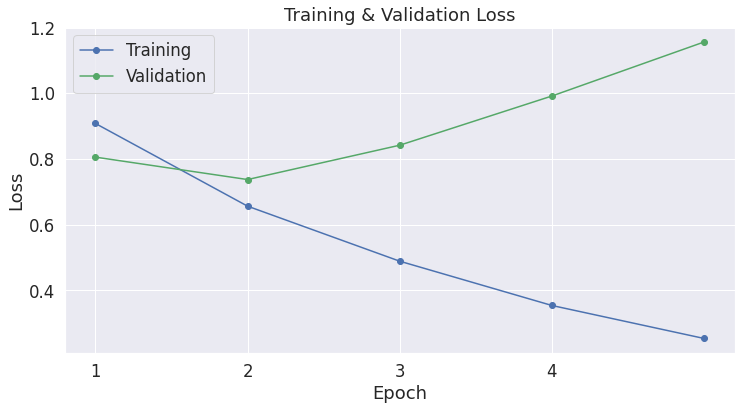

In [34]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
#sentences = test_dataframe['Headline'].values
#labels = test_dataframe['Headline sentiment'].values

In [35]:
test_dataframe

,Year,Article No,Sample_No,Relevance,Article Sentiment,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content
801,2004,16,NaN,1,1,1,1,1,22,1,XINCCN0020040816e08b000gp,802,（追忆小平）专访：改革开放政策使中国人民走向富裕──访意大利友好人士,新华社罗马８月１５日电专访：改革开放使中国人民走向富裕──访意大利友好人士 新...,这些都是邓小平倡导中国走改革开放道路的成功体现,（追忆小平）专访：改革开放政策使中国人民走向富裕──访意大利友好人士 \n 新华社罗...
4375,2012,9033,376.0,1,1,1,1,1,10,1,XINCCN0020120912e89c000jq,4376,曾俊华：香港经济发展新焦点是为国家提供高增值服务,新华社香港９月１２日电（记者苏晓）香港特区政府财政司司长曾俊华１２日表示，香港经济发展新焦点...,香港是一个很好平台，在海外发展过程中，为内地企业提供各种专业服务，令企业发展事半功倍,曾俊华：香港经济发展新焦点是为国家提供高增值服务\n新华社香港９月１２日电（记者苏晓）香港特...
880,2004,2732,NaN,1,1,1,1,1,11,1,XINCCN0020040909e099003xs,881,（中国投洽会）２００３年外商投资中国汽车工业取得飞速增长,取得飞速增长 新华社厦门９月９日电（记者康淼）商务部副部长马秀红９日在厦门说，２０...,今年５月，国家发改委还发布了新的《汽车产业发展政策》，积极扶持国内汽车产业健康发展...,（中国投洽会）２００３年外商投资中国汽车工业取得飞速增长 \n取得飞速增长 新华...
3437,2010,4177,NaN,1,1,3,1,3,12,3,XINCCN0020101213e6cd004xt,3438,【改稿】：Ｗ〔商务部：中国贸易投资促进团将随温家宝访印〕,２０１０年１２月１３日 修改后的稿件全文如下：商务部：中国贸易投资促进团将随温家宝访印新华社...,中国已经成为印度最大贸易夥伴，印度是中国第九大贸易夥伴,【改稿】：Ｗ〔商务部：中国贸易投资促进团将随温家宝访印〕\n２０１０年１２月１３日 修改后的...
3830,2011,5465,NaN,1,1,1,1,3,3,3,XINCCN0020110322e73m000ac,3831,商务部：“十二五”中国社会消费品零售总额将比“十一五”翻一番,在“十二五”规划实施期间，服务业的发展是一个重要指标,除了国内贸易的专项规划以外，姚坚表示，商务部还正编制另外１１个涉及海外投资、服务贸易发展、边...,商务部：“十二五”中国社会消费品零售总额将比“十一五”翻一番\n在“十二五”规划实施期间，服...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631,2016,2274,27.0,1,3,3,1,3,1,3,BEIJOS0020160301ec320002g,5644,GDP增速放缓 会滑出合理区间吗？,新京报今起推出“中国经济十五问”系列报道；全国政协十二届四次会议明日开幕\n\nA06-A1...,新京报今起推出“中国经济十五问”系列报道；全国政协十二届四次会议明日开幕\n\nA06-A1...,GDP增速放缓 会滑出合理区间吗？\n新京报今起推出“中国经济十五问”系列报道；全国政协十二...
7224,2020,1438,18.0,1,3,3,1,3,18,3,CNBNOS0020200318eg3i0008m,7263,北向资金连续6日大逃亡，机构称净流出逐步接近尾声,3月18日，北向资金净流出71.91亿元，其中沪股通净流出41.12亿元，深股通净流出30....,中长期科技产业周期与政策周期共振利好的5G建设及应用、半导体、新能源汽车、创新药械、高端制造...,北向资金连续6日大逃亡，机构称净流出逐步接近尾声\n3月18日，北向资金净流出71.91亿元...
948,2004,4744,NaN,1,3,1,1,1,12,3,XINCCN0020040316e03h0048t,949,（中外交流）薄熙来：中国愿积极扩大中美经贸关系,系 新华社北京３月１６日电（记者廖雷）中国商务部部长薄熙来１６日在北京会见到访的美...,薄熙来随后还会见了美国前总统国家安全事务助理伯杰，双方就在当前形势下，进一步发展中美...,（中外交流）薄熙来：中国愿积极扩大中美经贸关系 \n系 新华社北京３月１６日电（...
1521,2005,9572,NaN,1,3,3,1,3,22,3,XINCCN0020050530e15u000n9,1522,长三角与珠三角在竞争中合作,在传统上，“香港－深圳－广州”轴线才是珠江三角洲的生产者服务中心，金融、外贸、技术、法律、物...,两地企业完全可以通过联合并购扩大规模，积极走向资本市场，以共同推进两地企业的国际化,长三角与珠三角在竞争中合作 \n在传统上，“香港－深圳－广州”轴线才是珠江三角洲的生产者服...


In [36]:
test_dataframe.groupby('Article Sentiment').count()

,Year,Article No,Sample_No,Relevance,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content
Article Sentiment,,,,,,,,,,,,,,,
1,43,43,10,43,43,43,43,43,43,43,43,43,43,43,43
2,43,43,20,43,43,43,43,43,43,43,43,43,43,43,43
3,43,43,23,43,43,43,43,43,43,43,43,43,43,43,43


In [37]:
columns = ['Headline Sentiment', 'First para. Sentiment', 'Last para. sentiment', 'Article Sentiment']
for col in columns:
  test_dataframe[col] = test_dataframe[col].replace(2,0)
  test_dataframe[col] = test_dataframe[col].replace(1,2)
  test_dataframe[col] = test_dataframe[col].replace(3,1)

  

In [40]:
test_dataframe = test_dataframe[test_dataframe['First para. Sentiment']<=2]
test_dataframe = test_dataframe[test_dataframe['Last para. sentiment']<=2]
test_dataframe = test_dataframe[test_dataframe['Headline Sentiment']<=2]
test_dataframe

,Year,Article No,Sample_No,Relevance,Article Sentiment,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content
801,2004,16,NaN,1,2,2,1,2,22,2,XINCCN0020040816e08b000gp,802,（追忆小平）专访：改革开放政策使中国人民走向富裕──访意大利友好人士,新华社罗马８月１５日电专访：改革开放使中国人民走向富裕──访意大利友好人士 新...,这些都是邓小平倡导中国走改革开放道路的成功体现,（追忆小平）专访：改革开放政策使中国人民走向富裕──访意大利友好人士 \n 新华社罗...
4375,2012,9033,376.0,1,2,2,1,2,10,2,XINCCN0020120912e89c000jq,4376,曾俊华：香港经济发展新焦点是为国家提供高增值服务,新华社香港９月１２日电（记者苏晓）香港特区政府财政司司长曾俊华１２日表示，香港经济发展新焦点...,香港是一个很好平台，在海外发展过程中，为内地企业提供各种专业服务，令企业发展事半功倍,曾俊华：香港经济发展新焦点是为国家提供高增值服务\n新华社香港９月１２日电（记者苏晓）香港特...
880,2004,2732,NaN,1,2,2,1,2,11,2,XINCCN0020040909e099003xs,881,（中国投洽会）２００３年外商投资中国汽车工业取得飞速增长,取得飞速增长 新华社厦门９月９日电（记者康淼）商务部副部长马秀红９日在厦门说，２０...,今年５月，国家发改委还发布了新的《汽车产业发展政策》，积极扶持国内汽车产业健康发展...,（中国投洽会）２００３年外商投资中国汽车工业取得飞速增长 \n取得飞速增长 新华...
3437,2010,4177,NaN,1,2,1,1,1,12,1,XINCCN0020101213e6cd004xt,3438,【改稿】：Ｗ〔商务部：中国贸易投资促进团将随温家宝访印〕,２０１０年１２月１３日 修改后的稿件全文如下：商务部：中国贸易投资促进团将随温家宝访印新华社...,中国已经成为印度最大贸易夥伴，印度是中国第九大贸易夥伴,【改稿】：Ｗ〔商务部：中国贸易投资促进团将随温家宝访印〕\n２０１０年１２月１３日 修改后的...
3830,2011,5465,NaN,1,2,2,1,1,3,1,XINCCN0020110322e73m000ac,3831,商务部：“十二五”中国社会消费品零售总额将比“十一五”翻一番,在“十二五”规划实施期间，服务业的发展是一个重要指标,除了国内贸易的专项规划以外，姚坚表示，商务部还正编制另外１１个涉及海外投资、服务贸易发展、边...,商务部：“十二五”中国社会消费品零售总额将比“十一五”翻一番\n在“十二五”规划实施期间，服...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631,2016,2274,27.0,1,1,1,1,1,1,1,BEIJOS0020160301ec320002g,5644,GDP增速放缓 会滑出合理区间吗？,新京报今起推出“中国经济十五问”系列报道；全国政协十二届四次会议明日开幕\n\nA06-A1...,新京报今起推出“中国经济十五问”系列报道；全国政协十二届四次会议明日开幕\n\nA06-A1...,GDP增速放缓 会滑出合理区间吗？\n新京报今起推出“中国经济十五问”系列报道；全国政协十二...
7224,2020,1438,18.0,1,1,1,1,1,18,1,CNBNOS0020200318eg3i0008m,7263,北向资金连续6日大逃亡，机构称净流出逐步接近尾声,3月18日，北向资金净流出71.91亿元，其中沪股通净流出41.12亿元，深股通净流出30....,中长期科技产业周期与政策周期共振利好的5G建设及应用、半导体、新能源汽车、创新药械、高端制造...,北向资金连续6日大逃亡，机构称净流出逐步接近尾声\n3月18日，北向资金净流出71.91亿元...
948,2004,4744,NaN,1,1,2,1,2,12,1,XINCCN0020040316e03h0048t,949,（中外交流）薄熙来：中国愿积极扩大中美经贸关系,系 新华社北京３月１６日电（记者廖雷）中国商务部部长薄熙来１６日在北京会见到访的美...,薄熙来随后还会见了美国前总统国家安全事务助理伯杰，双方就在当前形势下，进一步发展中美...,（中外交流）薄熙来：中国愿积极扩大中美经贸关系 \n系 新华社北京３月１６日电（...
1521,2005,9572,NaN,1,1,1,1,1,22,1,XINCCN0020050530e15u000n9,1522,长三角与珠三角在竞争中合作,在传统上，“香港－深圳－广州”轴线才是珠江三角洲的生产者服务中心，金融、外贸、技术、法律、物...,两地企业完全可以通过联合并购扩大规模，积极走向资本市场，以共同推进两地企业的国际化,长三角与珠三角在竞争中合作 \n在传统上，“香港－深圳－广州”轴线才是珠江三角洲的生产者服...


In [41]:
test_dataframe.groupby('Article Sentiment').count()

,Year,Article No,Sample_No,Relevance,Headline Sentiment,First para. number,First para. Sentiment,Last para.no,Last para. sentiment,Id,UniqueId,Headline,First Paragraph,Last Paragraph,Content
Article Sentiment,,,,,,,,,,,,,,,
0,43,43,20,43,43,43,43,43,43,43,43,43,43,43,43
1,43,43,23,43,43,43,43,43,43,43,43,43,43,43,43
2,43,43,10,43,43,43,43,43,43,43,43,43,43,43,43


In [ ]:
"""import numpy as np
np.random.seed(0)

test_dataframe = test_dataframe.dropna()

remove_n = 150

drop_indices = np.random.choice(test_dataframe[test_dataframe['Article sentiment']==1].index, remove_n, replace=False)

test_dataframe = test_dataframe.drop(drop_indices)

np.random.seed(0)

remove_n = 10

drop_indices = np.random.choice(test_dataframe[test_dataframe['Article sentiment']==2].index, remove_n, replace=False)

test_dataframe = test_dataframe.drop(drop_indices)"""

In [ ]:
test_dataframe.groupby('Article Sentiment').count()

In [42]:
import pandas as pd
import numpy as np

# Create sentence and label lists
columnsSent = ['Headline Sentiment', 'First para. Sentiment', 'Last para. sentiment', 'Article Sentiment']
columnsContent = ['Headline', 'First Paragraph', 'Last Paragraph', 'Content']

allPredictions = []
allProbabilities = []

for index in range(len(columnsSent)):
  sentences = test_dataframe[columnsContent[index]].values
  labels = test_dataframe[columnsSent[index]].values

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Set the batch size.  
  batch_size = 8

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  # Prediction on test set

  print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
  model.load_state_dict(torch.load('best'))
  model.cuda()
  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels, probabilities = [], [], []

  # Predict 
  total_eval_accuracy=0
  idx=0
  for batch in prediction_dataloader:
    idx=idx+1
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits


    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels

    #print(np.exp(tf.nn.log_softmax(logits, axis=1)))
    #print(np.argmax(logits, axis=1).flatten())

    predictions.append(logits)
    true_labels.append(label_ids)
    probabilities.append(np.exp(tf.nn.log_softmax(logits, axis=1)))
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  allPredictions.append([np.argmax(prediction, axis=1).flatten() for prediction in predictions])
  allProbabilities.append(probabilities)

  print('    DONE.')
  print(total_eval_accuracy/idx)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 129 test sentences...
    DONE.
0.5661764705882353
Predicting labels for 129 test sentences...
    DONE.
0.5955882352941176
Predicting labels for 129 test sentences...
    DONE.
0.7132352941176471
Predicting labels for 129 test sentences...
    DONE.
0.6397058823529411


In [43]:
# from https://stackoverflow.com/questions/52885949/how-to-handle-no-unique-mode-found-2-equally-common-values-in-below-function
import collections

def get_all_modes(a):
    c = collections.Counter(a)  
    mode_count = max(c.values())
    mode = [key for key, count in c.items() if count == mode_count]
    return mode

In [44]:
#import statistics

allPredictions
finalPredictions = []
#finalPredictions.append(statistics.mode(
for batchNum in range(len(allPredictions[0])):
  for sampleNum in range(len(allPredictions[0][batchNum])):
      #print(statistics.mode([allPredictions[0][batchNum][sampleNum], allPredictions[1][batchNum][sampleNum], allPredictions[2][batchNum][sampleNum], allPredictions[3][batchNum][sampleNum]]))
      #print([allPredictions[0][batchNum][sampleNum], allPredictions[1][batchNum][sampleNum], allPredictions[2][batchNum][sampleNum], allPredictions[3][batchNum][sampleNum]])
      modes = get_all_modes([allPredictions[0][batchNum][sampleNum], allPredictions[1][batchNum][sampleNum], allPredictions[2][batchNum][sampleNum], allPredictions[3][batchNum][sampleNum]])
      print(modes)
      if len(modes) > 1:
        print(modes[0])
        one = allProbabilities[0][batchNum][sampleNum][modes[0]] + allProbabilities[1][batchNum][sampleNum][modes[0]] + allProbabilities[2][batchNum][sampleNum][modes[0]] + allProbabilities[3][batchNum][sampleNum][modes[0]]
        two = allProbabilities[0][batchNum][sampleNum][modes[1]] + allProbabilities[1][batchNum][sampleNum][modes[1]] + allProbabilities[2][batchNum][sampleNum][modes[1]] + allProbabilities[3][batchNum][sampleNum][modes[1]]
        if one > two:
          finalPredictions.append(modes[0])
        else:
          finalPredictions.append(modes[1])
        print(one,two)
      else:
        print(modes[0])
        finalPredictions.append(modes[0])
      #this = collections.Counter([allPredictions[0][batchNum][sampleNum], allPredictions[1][batchNum][sampleNum], allPredictions[2][batchNum][sampleNum], allPredictions[3][batchNum][sampleNum]])
      #print(this)
      #print(this.most_common(1))
      #print('\n')


[2]
2
[1]
1
[2]
2
[1, 2]
1
2.0573084 1.9371631
[2, 1]
2
1.9963297 1.9850587
[1]
1
[2]
2
[2]
2
[2]
2
[1]
1
[2]
2
[2]
2
[2, 0]
2
1.9532167 1.9667256
[1]
1
[2]
2
[0]
0
[2]
2
[2]
2
[2]
2
[1, 2]
1
2.1067986 1.8816028
[1, 2]
1
1.9803587 2.0114381
[1]
1
[2]
2
[2]
2
[2]
2
[1]
1
[2]
2
[2]
2
[2]
2
[2]
2
[1, 2]
1
2.046454 1.9329209
[0]
0
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[1]
1
[1]
1
[2]
2
[0]
0
[1, 0]
1
1.9658973 1.9244606
[0]
0
[0]
0
[0]
0
[0]
0
[1]
1
[0]
0
[0]
0
[0, 1]
0
2.1151805 1.8636844
[0]
0
[0]
0
[1, 0]
1
2.0953197 1.898029
[1]
1
[1]
1
[1, 0]
1
1.9090595 2.0762036
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[1, 0]
1
2.00423 1.9906137
[0]
0
[0]
0
[1]
1
[0]
0
[0]
0
[0]
0
[1]
1
[0]
0
[1, 0]
1
1.9771109 1.9734044
[0]
0
[0]
0
[0, 1]
0
1.9598017 2.024425
[0]
0
[0]
0
[0]
0
[0]
0
[1]
1
[0]
0
[0]
0
[0]
0
[1]
1
[1]
1
[2]
2
[1, 2]
1
2.1636152 1.8303151
[1]
1
[2]
2
[0]
0
[2, 1]
2
1.8053043 2.1098127
[1]
1
[1]
1
[1]
1
[1]
1
[1, 2]
1
2.0284247 1.9664416
[1, 2]
1
2.200729 1.7869413
[1, 2]
1
2.0196

In [ ]:
len(finalPredictions)

In [45]:
label_values = test_dataframe['Article Sentiment'].values
Total_accuracy = np.sum(finalPredictions == label_values) / len(label_values)
print('Majority Method Accuracy:', Total_accuracy)

Majority Method Accuracy: 0.6511627906976745


In [46]:
total_eval_accuracy = 0
for item in range(len(predictions)):
  total_eval_accuracy += flat_accuracy(predictions[item], true_labels[item])
  print(total_eval_accuracy)
print(total_eval_accuracy/idx)

0.75
1.5
2.375
3.125
4.125
5.125
5.875
6.625
7.375
8.25
9.125
9.625
10.125
10.375
10.75
10.875
10.875
0.6397058823529411


In [47]:
import pandas as pd

# Create sentence and label lists
sentences = test_dataframe['Content'].values
labels = test_dataframe['Article Sentiment'].values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
model.load_state_dict(torch.load('best'))
model.cuda()
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
total_eval_accuracy=0
idx=0
for batch in prediction_dataloader:
  idx=idx+1
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  total_eval_accuracy += flat_accuracy(logits, label_ids)


print('    DONE.')
print('Regular accuracy:', total_eval_accuracy/idx)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 129 test sentences...
    DONE.
Regular accuracy: 0.6397058823529411


In [ ]:
# How many predicted are actually correct
def precision(ground_truth, pred_labels, target):
  total = 0
  score = 0
  for num in range(len(ground_truth)):
    if pred_labels[num] == target:
      total += 1
      if ground_truth[num] == target:
        score += 1
  return score/total

In [ ]:
# How many out of test set were actually rememebered
def recall(ground_truth, pred_labels, target):
  total = 0
  score = 0
  for num in range(len(ground_truth)):
    if ground_truth[num] == target:
      total += 1
      if pred_labels[num] == target:
        score += 1
  return score/total

In [ ]:
# Metric to measure precision against recall
def f1_score(ground_truth, pred_labels, target):
  prec = precision(ground_truth, pred_labels, target)
  rec = recall(ground_truth, pred_labels, target)
  return 2 * prec * rec / (prec+rec)

In [ ]:
#precision(label_values, finalPredictions, 1)

In [ ]:
#recall(label_values, finalPredictions, 1)

In [ ]:
#f1_score(label_values, finalPredictions, 1)

In [49]:
"""all=[]
for x in predictions:
  pred_flat = np.argmax(x, axis=1).flatten()
  for a in pred_flat:
    all.append(a)

len(all)
true=[]
for x in true_labels:
  for a in x:
    true.append(a)
true
len(true)
f1_score(true,all,average='micro')"""

from sklearn.metrics import classification_report
#target_names = ['relevant', 'irrelevant'] # for relevance

target_names = ['negative', 'neutral', 'positive']
#target_names = ['negative', 'positive']
#target_names = ['non-positive', 'positive']

#print(classification_report(true, all, target_names=target_names))
print(classification_report(label_values, finalPredictions, target_names=target_names))
              

              precision    recall  f1-score   support

    negative       0.80      0.74      0.77        43
     neutral       0.51      0.53      0.52        43
    positive       0.66      0.67      0.67        43

    accuracy                           0.65       129
   macro avg       0.66      0.65      0.65       129
weighted avg       0.66      0.65      0.65       129



In [50]:
all=[]
for x in predictions:
  pred_flat = np.argmax(x, axis=1).flatten()
  for a in pred_flat:
    all.append(a)

len(all)
true=[]
for x in true_labels:
  for a in x:
    true.append(a)
true
len(true)
#f1_score(true,all,average='micro')

from sklearn.metrics import classification_report
#target_names = ['relevant', 'irrelevant'] # for relevance

target_names = ['negative', 'neutral', 'positive']
#target_names = ['negative', 'positive']
#target_names = ['non-positive', 'positive']

#print(classification_report(true, all, target_names=target_names))
print(classification_report(true, all, target_names=target_names))
              

              precision    recall  f1-score   support

    negative       0.78      0.81      0.80        43
     neutral       0.52      0.37      0.43        43
    positive       0.68      0.84      0.75        43

    accuracy                           0.67       129
   macro avg       0.66      0.67      0.66       129
weighted avg       0.66      0.67      0.66       129



In [ ]:
import collections, numpy
collections.Counter(label_values)

In [ ]:
# ceiling of the majority method

article_vals = test_dataframe['Article Sentiment'].values
headline_vals = test_dataframe['Headline Sentiment'].values
first_vals = test_dataframe['First para. Sentiment'].values
last_vals = test_dataframe['Last para. sentiment'].values

majority_vals = []

for num in range(len(article_vals)):
  modes = get_all_modes([article_vals[num], headline_vals[num], first_vals[num], last_vals[num]])
  if len(modes) > 1:
    majority_vals.append(article_vals[num]) # article_vals[num]
  else:
    majority_vals.append(modes[0])

print(np.sum(majority_vals == article_vals) / len(majority_vals))
  

In [ ]:
top = 0.9171270718232044
bottom = 0.8342541436464088

In [ ]:
from sklearn.metrics import classification_report
#target_names = ['relevant', 'irrelevant'] # for relevance

#target_names = ['negative', 'neutral', 'positive']
target_names = ['negative', 'positive']

#print(classification_report(true, all, target_names=target_names))
print(classification_report(article_vals, majority_vals, target_names=target_names))

# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.